In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-03-30 18:30:53--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.007s  

2021-03-30 18:30:53 (8.90 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



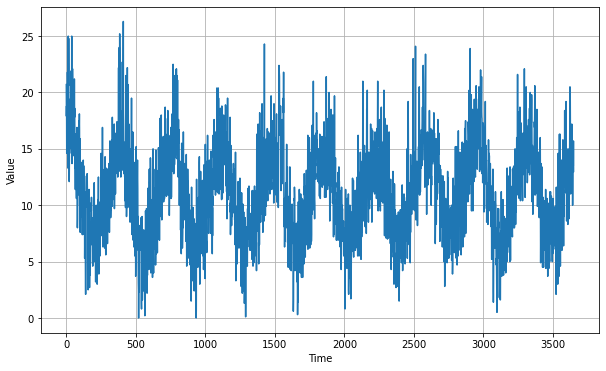

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 124
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 30
batch_size = 124
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.GRU(300, return_sequences=True),
  tf.keras.layers.GRU(200, return_sequences=True),
  tf.keras.layers.GRU(100, return_sequences=True),
  tf.keras.layers.Dense(90, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=200, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/200
20/20 [==============================] - 35s 22ms/step - loss: 10.6695 - mae: 11.1688
Epoch 2/200
20/20 [==============================] - 0s 16ms/step - loss: 10.7827 - mae: 11.2820
Epoch 3/200
20/20 [==============================] - 0s 15ms/step - loss: 10.7711 - mae: 11.2703
Epoch 4/200
20/20 [==============================] - 0s 15ms/step - loss: 10.6979 - mae: 11.1971
Epoch 5/200
20/20 [==============================] - 0s 15ms/step - loss: 10.6540 - mae: 11.1531
Epoch 6/200
20/20 [==============================] - 0s 15ms/step - loss: 10.6446 - mae: 11.1437
Epoch 7/200
20/20 [==============================] - 0s 16ms/step - loss: 10.7226 - mae: 11.2218
Epoch 8/200
20/20 [==============================] - 0s 15ms/step - loss: 10.7105 - mae: 11.2097
Epoch 9/200
20/20 [==============================] - 0s 15ms/step - loss: 10.6776 - mae: 11.1767
Epoch 10/200
20/20 [====

KeyboardInterrupt: ignored

(1e-06, 0.1, 0.0, 60.0)

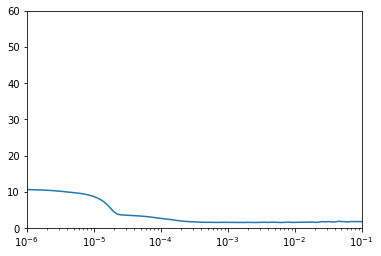

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-1, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size=30
batch_size=124
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
valid_set=windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.GRU(300, return_sequences=True),
  tf.keras.layers.GRU(200, return_sequences=True),
  tf.keras.layers.GRU(100, return_sequences=True),
  tf.keras.layers.Dense(90, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=3e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
#early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
history = model.fit(train_set, validation_data=valid_set, epochs=200,callbacks=[model_checkpoint])


Epoch 1/200
20/20 [==============================] - 5s 73ms/step - loss: 10.3971 - mae: 10.8960 - val_loss: 10.6536 - val_mae: 11.1533
Epoch 2/200
20/20 [==============================] - 1s 24ms/step - loss: 9.7796 - mae: 10.2781 - val_loss: 9.3938 - val_mae: 9.8923
Epoch 3/200
20/20 [==============================] - 1s 24ms/step - loss: 8.2022 - mae: 8.6991 - val_loss: 6.1236 - val_mae: 6.6143
Epoch 4/200
20/20 [==============================] - 1s 25ms/step - loss: 4.6219 - mae: 5.1021 - val_loss: 3.1771 - val_mae: 3.6491
Epoch 5/200
20/20 [==============================] - 1s 23ms/step - loss: 3.2887 - mae: 3.7597 - val_loss: 3.1878 - val_mae: 3.6594
Epoch 6/200
20/20 [==============================] - 1s 26ms/step - loss: 3.1706 - mae: 3.6391 - val_loss: 3.1329 - val_mae: 3.6037
Epoch 7/200
20/20 [==============================] - 1s 26ms/step - loss: 3.1126 - mae: 3.5812 - val_loss: 3.0577 - val_mae: 3.5275
Epoch 8/200
20/20 [==============================] - 1s 25ms/step - los

In [19]:
history = model.fit(train_set, validation_data=valid_set, epochs=50,callbacks=[model_checkpoint])

Epoch 1/50
20/20 [==============================] - 3s 69ms/step - loss: 1.4831 - mae: 1.9231 - val_loss: 1.3879 - val_mae: 1.8247
Epoch 2/50
20/20 [==============================] - 1s 23ms/step - loss: 1.4826 - mae: 1.9225 - val_loss: 1.3869 - val_mae: 1.8239
Epoch 3/50
20/20 [==============================] - 1s 24ms/step - loss: 1.4827 - mae: 1.9224 - val_loss: 1.3978 - val_mae: 1.8366
Epoch 4/50
20/20 [==============================] - 1s 24ms/step - loss: 1.4851 - mae: 1.9251 - val_loss: 1.3862 - val_mae: 1.8230
Epoch 5/50
20/20 [==============================] - 1s 25ms/step - loss: 1.4814 - mae: 1.9209 - val_loss: 1.3908 - val_mae: 1.8280
Epoch 6/50
20/20 [==============================] - 1s 26ms/step - loss: 1.4811 - mae: 1.9212 - val_loss: 1.3868 - val_mae: 1.8238
Epoch 7/50
20/20 [==============================] - 1s 26ms/step - loss: 1.4825 - mae: 1.9225 - val_loss: 1.3935 - val_mae: 1.8313
Epoch 8/50
20/20 [==============================] - 1s 25ms/step - loss: 1.4852 - m

Text(0.5, 1.0, 'Training and validation loss')

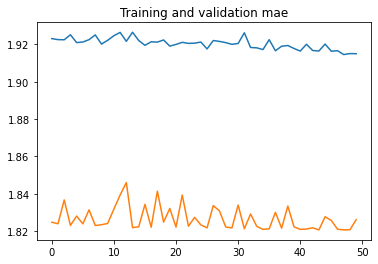

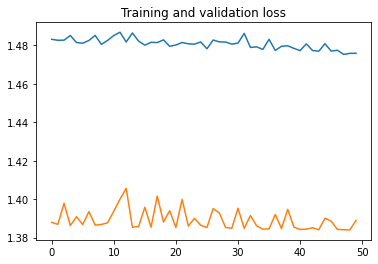

In [20]:
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae      = history.history[     'mae' ]
val_mae  = history.history[ 'val_mae' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(mae)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     mae )
plt.plot  ( epochs, val_mae )
plt.title ('Training and validation mae')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

ValueError: ignored

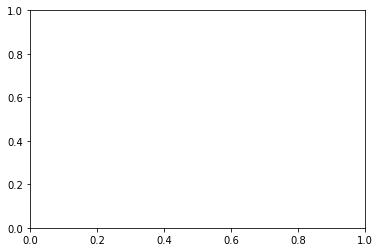

In [21]:
epochs   = range(len(mae))
zoom_point=len(mae)-80
zoomed_mae = mae[zoom_point:]
zoomed_v_mae = val_mae[zoom_point:]
zoomed_epochs = range(zoom_point,len(mae))


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_mae, 'b')
plt.plot(zoomed_epochs, zoomed_v_mae, 'r')

In [22]:
model = tf.keras.models.load_model("my_checkpoint.h5")

In [23]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

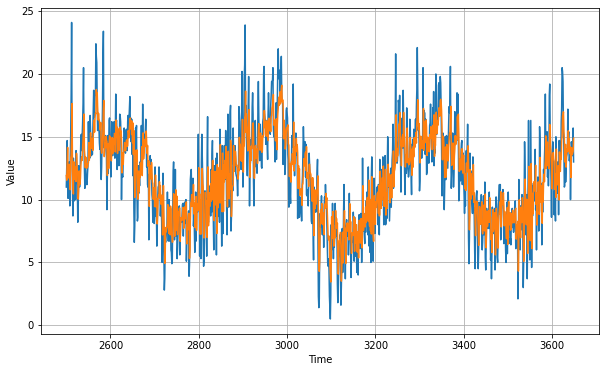

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7971221

In [17]:
print(rnn_forecast)

[12.032793  11.612574  13.154806  ... 13.6888275 13.8102455 14.885374 ]
